In [2]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle 
import os

data = pd.read_csv('dataset.csv')
data = shuffle(data)
X = data.drop('label', axis=1).values
y = data['label'].values


X = X / 255.0


In [3]:
class StandardScaler:
    def fit_transform(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        self.std_ = np.where(self.std_ == 0, 1e-8, self.std_)

        return (X - self.mean_) / self.std_

scaler = StandardScaler()
X = scaler.fit_transform(X) 


In [4]:
def train_test_split_custom(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    X = X[indices]
    y = y[indices]
    
    split_index = int((1 - test_size) * len(X))
    
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_custom(X, y, test_size=0.2, random_state=42)

In [5]:
class KMeans:
    def __init__(self, k=10, max_iters=100, tol=1e-4):
        self.k = k 
        self.max_iters = max_iters
        self.tol = tol 
    def fit(self, X):
        np.random.seed(42)
        random_indices = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iters):
            self.labels_ = self._assign_labels(X)
            new_centroids = self._update_centroids(X)
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break

            self.centroids = new_centroids
    def _assign_labels(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X):
        new_centroids = np.array([X[self.labels_ == i].mean(axis=0) for i in range(self.k)])
        return new_centroids

    def predict(self, X):
        return self._assign_labels(X)

In [6]:
kmeans = KMeans(k=10)
kmeans.fit(X_train)
cluster_labels = np.zeros(10)

for i in range(10):
    cluster_points = y_train[kmeans.labels_ == i]
    cluster_labels[i] = Counter(cluster_points).most_common(1)[0][0]
    
print(cluster_labels)
y_pred = []

for test_point in X_test:
    closest_cluster_idx = np.argmin(np.linalg.norm(test_point - kmeans.centroids, axis=1))
    y_pred.append(cluster_labels[closest_cluster_idx])


[4. 7. 2. 2. 0. 5. 6. 0. 8. 3.]


In [7]:
import numpy as np
from sklearn.metrics import accuracy_score

y_pred = []

for test_point in X_test:
    closest_cluster_idx = np.argmin(np.linalg.norm(test_point - kmeans.centroids, axis=1))
    y_pred.append(closest_cluster_idx) 

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 34.50%


In [8]:

conf_matrix = np.zeros((10, 10), dtype=int)

for true, pred in zip(y_test, y_pred):
    conf_matrix[true, pred] += 1

precision = np.zeros(10)
recall = np.zeros(10)
f1_score = np.zeros(10)

for i in range(10):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    # Precision and recall
    precision[i] = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall[i] = TP / (TP + FN) if (TP + FN) != 0 else 0

    # F1-score
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0

accuracy = np.sum(y_pred == y_test) / len(y_test)

macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1_score = np.mean(f1_score)

support = np.array([np.sum(y_test == i) for i in range(10)])
weighted_precision = np.sum(precision * support) / np.sum(support)
weighted_recall = np.sum(recall * support) / np.sum(support)
weighted_f1_score = np.sum(f1_score * support) / np.sum(support)

results = {
    'Metric': ['Accuracy', 'Macro-Precision', 'Macro-Recall', 'Macro-F1-Score',
               'Weighted-Precision', 'Weighted-Recall', 'Weighted-F1-Score'],
    'Score': [accuracy * 100, macro_precision * 100, macro_recall * 100, macro_f1_score * 100,
              weighted_precision * 100, weighted_recall * 100, weighted_f1_score * 100]
}

df_results = pd.DataFrame(results)



print("Confusion Matrix:")
print(conf_matrix)
print("\nAnalysis:")
print(df_results)

Confusion Matrix:
[[ 0  0  0  0  0  1  0  8  5  0]
 [ 0  1  4  0  0  3 11  0  0  1]
 [ 0  0 20  2  0  2  2  0  0  0]
 [ 0  1 10  0  0  2  0  0  5  5]
 [ 9  0  0  0  0  2  2  0  2  0]
 [ 1  0  0  0  0 12  0  0  6  5]
 [ 0  1  0  0  0  0 19  0  0  0]
 [ 0 23  0  0  0  0  1  0  0  0]
 [ 0  1  0  0  0  0  0  0 17  0]
 [ 0 15  0  0  0  0  0  0  1  0]]

Analysis:
               Metric      Score
0            Accuracy  34.500000
1     Macro-Precision  21.725787
2        Macro-Recall  32.136752
3      Macro-F1-Score  25.412026
4  Weighted-Precision  24.109180
5     Weighted-Recall  34.500000
6   Weighted-F1-Score  27.825874


In [105]:
import joblib

joblib.dump(kmeans, 'model/digit_recognizer_4')

['model/digit_recognizer_4']

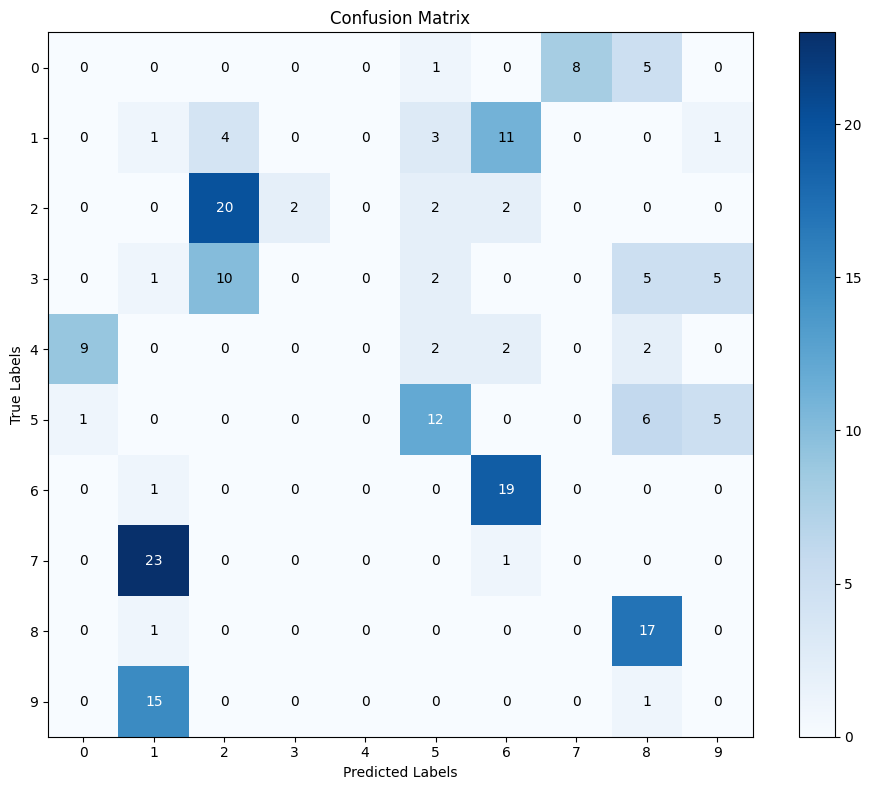

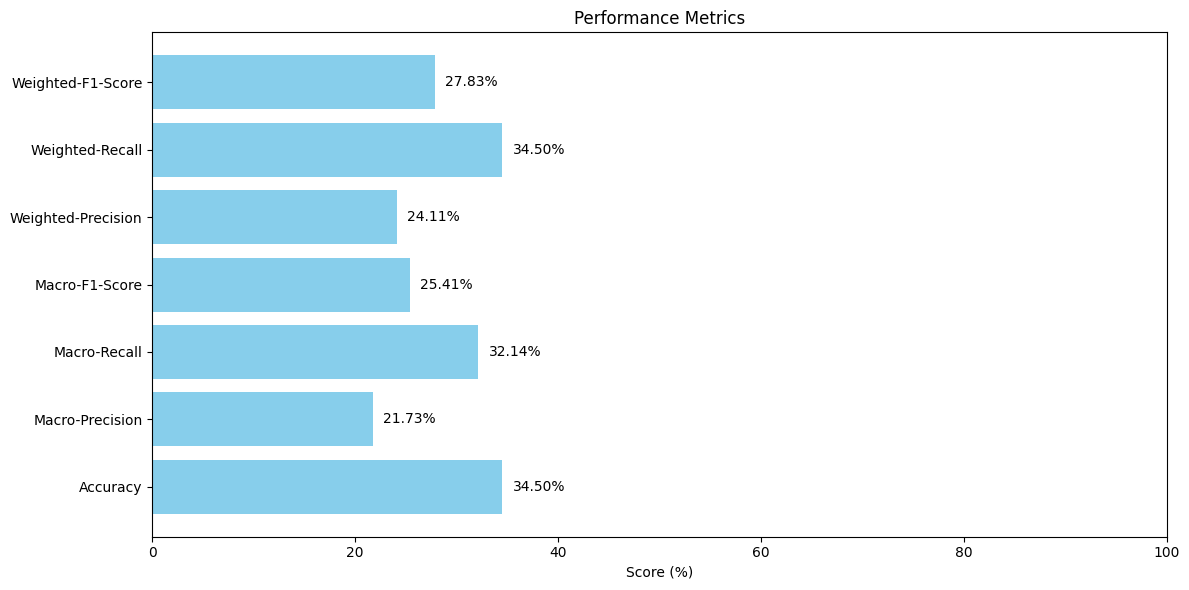

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Add labels to the heatmap
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.show()

# Plotting the Performance Metrics
metrics = ['Accuracy', 'Macro-Precision', 'Macro-Recall', 'Macro-F1-Score',
           'Weighted-Precision', 'Weighted-Recall', 'Weighted-F1-Score']
scores = [accuracy * 100, macro_precision * 100, macro_recall * 100, macro_f1_score * 100,
          weighted_precision * 100, weighted_recall * 100, weighted_f1_score * 100]

plt.figure(figsize=(12, 6))
plt.barh(metrics, scores, color='skyblue')
plt.title("Performance Metrics")
plt.xlabel("Score (%)")
plt.xlim(0, 100)

# Annotate bar chart with scores
for i, score in enumerate(scores):
    plt.text(score + 1, i, f"{score:.2f}%", va='center')

plt.tight_layout()
plt.show()


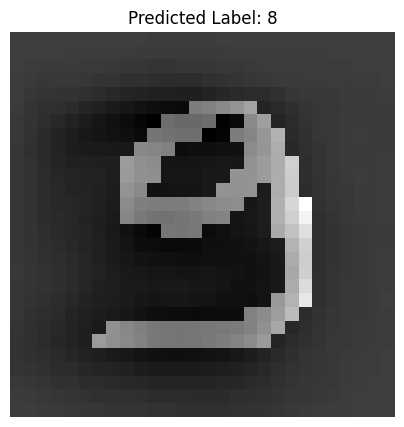

In [106]:
from matplotlib import pyplot as plt
idx = 2
img = X_test[idx].reshape(28, 28)
predicted_label = y_pred[idx]
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()

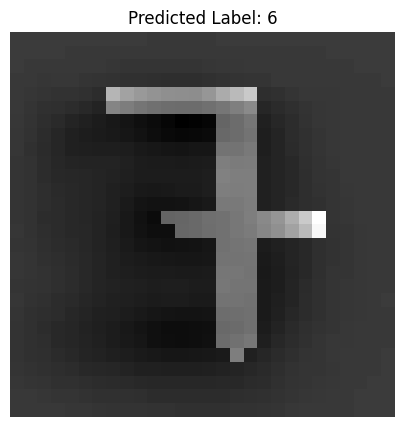

In [107]:
from matplotlib import pyplot as plt
idx = 3
img = X_test[idx].reshape(28, 28)
predicted_label = y_pred[idx]
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()

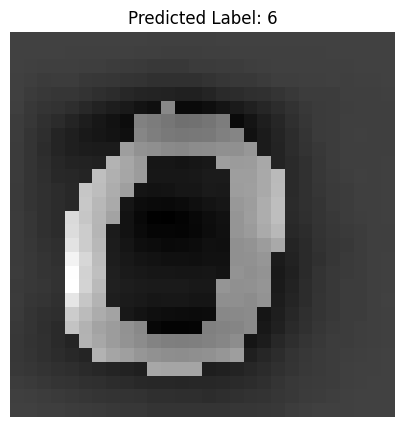

In [108]:
from matplotlib import pyplot as plt
idx = 1
img = X_test[idx].reshape(28, 28)
predicted_label = y_pred[idx]
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()

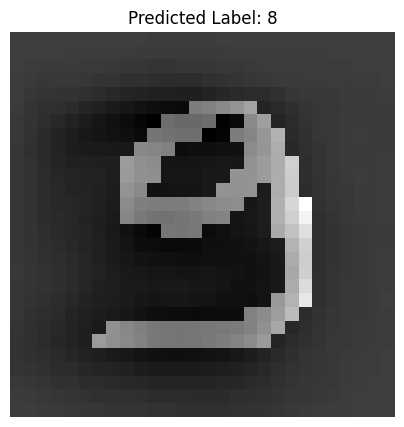

In [109]:
from matplotlib import pyplot as plt
idx = 2
img = X_test[idx].reshape(28, 28)
predicted_label = y_pred[idx]
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()